<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week12-SVM/SVM-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np


class SVM:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hinge Loss Function / Calculation
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0][0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros((1, number_of_features))
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            # Calculating the gradients

                            #w.r.t w 
                            gradw += c * -1 * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * -1 * Y[x]

                # Updating weights and bias
                w = w - learning_rate * gradw
                b = b - learning_rate * gradb
        
        self.w = w
        self.b = b

        return self.w, self.b, losses

    def predict(self, X):
        
        prediction = np.dot(X, self.w[0]) + self.b # w.x + b
        return np.sign(prediction)

In [116]:
# prediction.py

from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(

        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=40
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [118]:
svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

In [119]:
prediction = svm.predict(X_test)

# Loss value
lss = losses.pop()

print("Loss:", lss)
print("Prediction:", prediction)
print("Accuracy:", accuracy_score(prediction, y_test))
print("w, b:", [w, b])

Loss: 0.10146179096160396
Prediction: [-1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.
  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
Accuracy: 1.0
w, b: [array([[0.4504704 , 0.14665864]]), 0.023000000000000007]


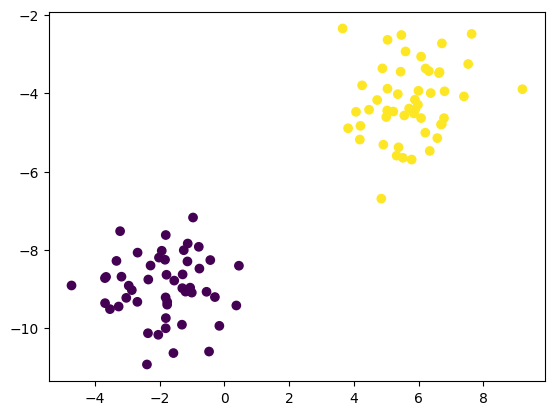

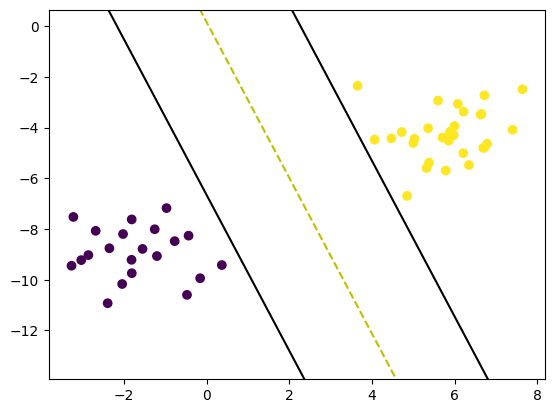

In [120]:
# Visualizing the scatter plot of the dataset
def visualize_dataset():
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm():

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0][0] * x + b + offset) / w[0][1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test)

    x0_1 = np.amin(X_test[:, 0])
    x0_2 = np.amax(X_test[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset()
visualize_svm()

In [121]:
#Credit: https://github.com/python-engineer/MLfromscratch
import numpy as np 
import matplotlib.pyplot as plt
import random

class SVM:

    def __init__(self, learning_rate=0.01, penalty_rate=1, niter =1000):
        self.lr = learning_rate
        self.n_iters = niter
        self.w = None
        self.b = None
        self.penalty_rate = penalty_rate

    def fit(self, X, y):
        n_samples, n_features = X.shape  
        self.w = np.array([1,-1])
        self.b = 0
        X_ = X
        y_ = y
        self.d = 1
        C = 1

        for i in range(self.n_iters+1):
          
          tmpW = 0
          tmpB = 0
          #idx is index, x_i is a vector
          for idx, x_i in enumerate(X_):
            eq = y_[idx] * (np.dot(x_i, self.w) + self.b)
            print(eq)
            
            condition = (eq >= self.d) # True or False
            
            if condition:
              #self.w = self.w - self.lr * (self.penalty_rate * self.w)
              tmpW += 0 
            else: #misclassified
              #self.w = self.w - self.lr * ( self.penalty_rate * self.w - (C * np.multiply(x_i, y_[idx])))
              tmpW += (-1*np.multiply(x_i, y_[idx]))

            #self.b = self.b - self.lr * C * (-1 * y_[idx]) 
            tmpB += (-1 * y_[idx])
          
          #print("tmpW = ",tmpW)
          #print("tmpB = ",tmpB)
          self.w = self.w - self.lr * (self.w + (C * (tmpW)))
          self.b = self.b - self.lr * (tmpB)

          if i% (self.n_iters/10) == 0:
            print("i= ",i," W = ",self.w," b = ",self.b)

          if i == self.n_iters-1:
            self.visualize_svm(self.w, self.b, X, y)
                   
    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)
    
    def visualize_svm(self, w, b, X, y):

        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        plt.scatter(X[:,0], X[:,1], marker='o',c=y)
        #plt.ylim(-20, 20)
        #plt.xlim(-20,20)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x0_1 = np.amin(X[:,0])
        x0_2 = np.amax(X[:,0])

        x1_1 = get_hyperplane_value(x0_1, w, b, 0)
        x1_2 = get_hyperplane_value(x0_2, w, b, 0)

        x1_1_m = get_hyperplane_value(x0_1, w, b, -self.d)
        x1_2_m = get_hyperplane_value(x0_2, w, b, -self.d)

        x1_1_p = get_hyperplane_value(x0_1, w, b, self.d)
        x1_2_p = get_hyperplane_value(x0_2, w, b, self.d)

        ax.plot([x0_1, x0_2],[x1_1, x1_2], 'b--')
        ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'g')
        ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'r')

        x1_min = np.amin(X[:,1])
        x1_max = np.amax(X[:,1])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        plt.show()

    

1.0
-1.0
1.0
i=  0  W =  [ 0.99 -0.98]  b =  0.01
0.98
-0.97
1.0
0.9701
-0.9401999999999999
1.0101
0.9601989999999999
-0.9105979999999999
1.0201989999999999
0.9502970099999999
-0.8811920199999999
1.03029701
0.9403940398999999
-0.8519800997999999
1.0403940399
0.9304900995009999
-0.8229602988019998
1.050490099501
0.9205851985059901
-0.79413069581398
1.06058519850599
0.9106793465209302
-0.7654893888558402
1.07067934652093
0.9007725530557209
-0.7370344949672818
1.0807725530557208
0.8908648275251637
-0.708764150017609
1.0908648275251638
i=  10  W =  [ 0.99095618 -0.79067651]  b =  0.10999999999999999
0.8809561792499121
-0.6806765085174329
1.100956179249912
0.871046617457413
-0.6527697434322586
1.111046617457413
0.8611361512828388
-0.625042045997936
1.1211361512828388
0.8512247897700105
-0.5974916255379566
1.1312247897700105
0.8413125418723104
-0.5701167092825771
1.1413125418723105
0.8313994164535873
-0.5429155421897512
1.1513994164535872
0.8214854222890514
-0.5158863867678537
1.161485422289

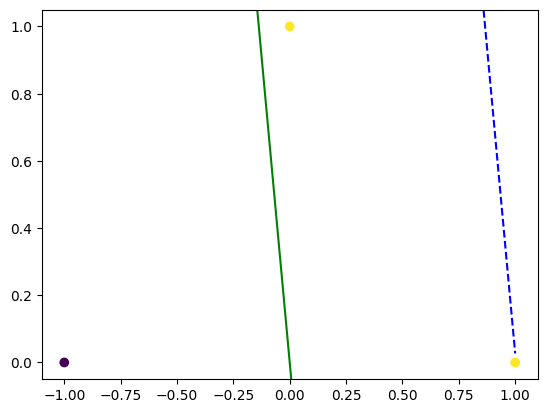

-0.0036972963764981825
1.1366811302225202
1.996302703623503
i=  100  W =  [0.99633968 0.13531432]  b =  1.0100000000000007
sklearn w= [[1. 1.]]  b= [-0.]


In [122]:
import numpy as np
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#X, y =  datasets.make_blobs(n_samples=20, n_features=2, centers=2, cluster_std=1, random_state=123)

X = np.array([[-1.0,0.0],[0.0,1.0],[1.0,0.0]])
y = np.array([0,1,1])

y = np.where(y == 0, -1, 1)
#print(X, " ", y)

clf = SVM(niter=100)
clf.fit(X, y)
#print("Our w=", clf.w, " b=", clf.b)

#Recommend
clf2 = SVC(kernel='linear')
#SVC(kernel="linear")
clf2.fit(X,y)
print("sklearn w=",clf2.coef_," b=",clf2.intercept_)


In [123]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

array([[-1.,  0.],
       [ 0.,  1.]])

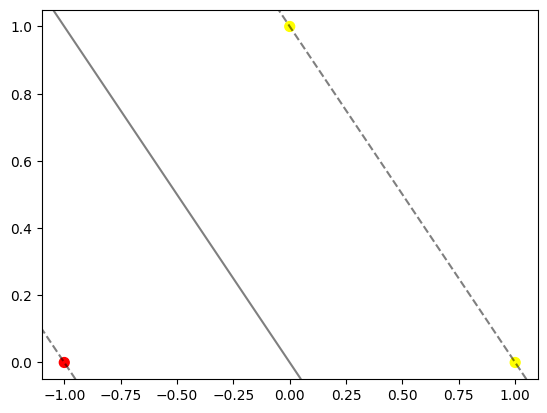

In [124]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf2);
clf2.support_vectors_

# Exercise
1. Create a hinge loss function and use it to check when to stop training.
2. Implement Stochastic GD version.